In [45]:
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
learning_rate = 0.001
num_steps = 2000
batch_size = 128

num_input = 784
num_classes = 100
dropout = 0.25

In [0]:
def conv_net(x_dict, num_classes, dropout, reuse, is_training):

  #Defining a scope for resuing the variables
  with tf.variable_scope('ConvNet', reuse=reuse):
    #TF Estimator for reusing the variables
    x = x_dict['image']
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

    conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    fc1 = tf.layers.dropout(fc1,rate=dropout, training=is_training)

    out = tf.layers.dense(fc1, num_classes)

  return out

In [0]:
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [49]:
model = tf.estimator.Estimator(model_fn=model_fn)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image': mnist.train.images},
    y = mnist.train.labels,
    batch_size = batch_size,
    num_epochs = None,
    shuffle = True)
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpm2nng8ri', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8271a26b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done c

In [51]:
input_fn = tf.estimator.inputs.numpy_input_fn(
  x={'image': mnist.test.images}, 
  y=mnist.test.labels,
  batch_size=batch_size, shuffle=False)

model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-30T10:23:15Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpm2nng8ri/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-30-10:23:15
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9887, global_step = 2000, loss = 0.034248296
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpm2nng8ri/model.ckpt-2000


{'accuracy': 0.9887, 'global_step': 2000, 'loss': 0.034248296}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpm2nng8ri/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


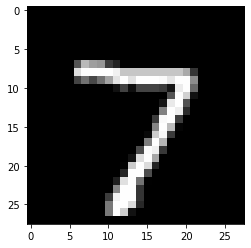

Model prediction: 7


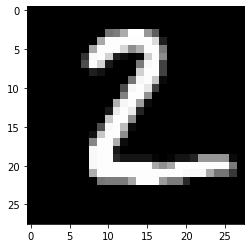

Model prediction: 2


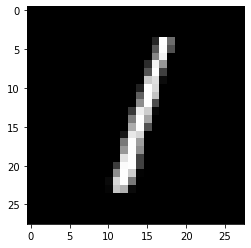

Model prediction: 1


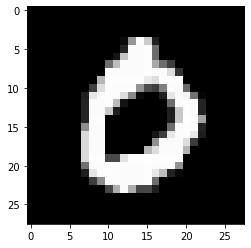

Model prediction: 0


In [53]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])